<a href="https://colab.research.google.com/github/Leucocitokiller/Dataframes---Machine-Learning/blob/main/Proyecto_final_MLIII_Libenson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final NLP y Redes Neuronales.

# Introducción

## Se realizará un analisis de sentimientos usando una lista de comentarios respecto a comidas de distintos restaurantes.

# Fuente de datos.

## Importación de librerias

In [99]:
import urllib.request
import numpy as np
import pandas as pd
import os
import time
import sys
#-----librerias para trabajar PLN
!python -m spacy download es_core_news_md
import spacy
import es_core_news_md
#es_core_news_md Medium (modelo mediano):
#Es más pesado y más lento que el sm, pero mucho más preciso. Tiene vectores de palabras, entiende mejor el significado de las palabras.

#-----instalación d librerias para análisis de sentimientos.
!pip install spacy spacy-transformers
!pip install pysentimiento
from pysentimiento import create_analyzer

#----librerias para normalización de textos
import re
from unicodedata import normalize
import unicodedata
from collections import Counter


#----librerias para graficar y wordcloud.
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

#----librerías para trabajar con TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
#----libreria para trabajar con BoW.
from sklearn.feature_extraction.text import CountVectorizer
#----librerias para Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 14.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Lectura de los datos desde Github

In [36]:
# Diccionario con las fuentes y sus URLs
filepath_dict = {
    'yelp': 'https://raw.githubusercontent.com/Leucocitokiller/Proyecto-Fina-NLP/main/yelp_comentarios.csv',
    'amazon': 'https://raw.githubusercontent.com/Leucocitokiller/Proyecto-Fina-NLP/main/amazon_cells_comentarios.csv'

}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['Comentario', 'Valor'], sep=';', encoding='latin-1')
    df['Origen'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df.head(1100)

,Comentario,Valor,Origen
0,Wow ... Me encantó este lugar.,1,yelp
1,La corteza no es buena.,0,yelp
2,No sabroso y la textura era simplemente desagr...,0,yelp
3,Me detuve durante las vacaciones de fines de m...,1,yelp
4,"La selección en el menú era genial, al igual q...",1,yelp
...,...,...,...
96,"Si planeas usar esto en un auto, olvídalo.",0,amazon
97,Encontré este producto demasiado grande.,0,amazon
98,Lo mejor que he encontrado hasta ahora ... He ...,1,amazon
99,Estoy muy decepcionado con mi decisión.,0,amazon


# Normalización de la fuente de datos.

## En el proceso de Normalización de datos, se realizará lo siguiente:

### 1. Eliminación de signos de puntuación.
### 2. Reducir a minúsculas todo el texto.
### 3. Convertir a número la columna Valor para su postprocesamiento.

## 1. Eliminación de signos de puntuación

In [37]:
# Definición de función para eliminar los signos de puntuación utilizando re, pero considerando no borrar las vocales con acento.

def remove_punctuation(text):
    # Normaliza el texto a NFKD para separar letras y sus tildes
    text = unicodedata.normalize('NFKD', text)
    # Elimina los caracteres diacríticos (como las tildes)
    text = ''.join(c for c in text if not unicodedata.combining(c))
    # Elimina todo lo que no sea letras, números o espacios
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text


# Aplicar la función a la columna 'review_lower'
df['Comentarios'] = df['Comentario'].apply(remove_punctuation)

In [38]:
df

,Comentario,Valor,Origen,Comentarios
0,Wow ... Me encantó este lugar.,1,yelp,Wow Me encanto este lugar
1,La corteza no es buena.,0,yelp,La corteza no es buena
2,No sabroso y la textura era simplemente desagr...,0,yelp,No sabroso y la textura era simplemente desagr...
3,Me detuve durante las vacaciones de fines de m...,1,yelp,Me detuve durante las vacaciones de fines de m...
4,"La selección en el menú era genial, al igual q...",1,yelp,La seleccion en el menu era genial al igual qu...
...,...,...,...,...
995,La pantalla se mancha fácilmente porque toca l...,0,amazon,La pantalla se mancha facilmente porque toca l...
996,Qué pedazo de chatarra ... Pierdo más llamadas...,0,amazon,Que pedazo de chatarra Pierdo mas llamadas en...
997,El artículo no coincide con la imagen.,0,amazon,El articulo no coincide con la imagen
998,Lo Ãºnico que me decepcionó es el puerto infra...,0,amazon,Lo Aonico que me decepciono es el puerto infra...


### Se puede observar que la puntuación se eliminó, y las palabras con acentos mantuvieron las vocales para mayor legibilidad.

## 2. Reducir a minúsculas todo el texto.

In [39]:
# Create a new column 'Comentarios_lower' with lowercase values from 'Comentario'
df['Comentarios_lower'] = df['Comentarios'].str.lower()

In [40]:
df

,Comentario,Valor,Origen,Comentarios,Comentarios_lower
0,Wow ... Me encantó este lugar.,1,yelp,Wow Me encanto este lugar,wow me encanto este lugar
1,La corteza no es buena.,0,yelp,La corteza no es buena,la corteza no es buena
2,No sabroso y la textura era simplemente desagr...,0,yelp,No sabroso y la textura era simplemente desagr...,no sabroso y la textura era simplemente desagr...
3,Me detuve durante las vacaciones de fines de m...,1,yelp,Me detuve durante las vacaciones de fines de m...,me detuve durante las vacaciones de fines de m...
4,"La selección en el menú era genial, al igual q...",1,yelp,La seleccion en el menu era genial al igual qu...,la seleccion en el menu era genial al igual qu...
...,...,...,...,...,...
995,La pantalla se mancha fácilmente porque toca l...,0,amazon,La pantalla se mancha facilmente porque toca l...,la pantalla se mancha facilmente porque toca l...
996,Qué pedazo de chatarra ... Pierdo más llamadas...,0,amazon,Que pedazo de chatarra Pierdo mas llamadas en...,que pedazo de chatarra pierdo mas llamadas en...
997,El artículo no coincide con la imagen.,0,amazon,El articulo no coincide con la imagen,el articulo no coincide con la imagen
998,Lo Ãºnico que me decepcionó es el puerto infra...,0,amazon,Lo Aonico que me decepciono es el puerto infra...,lo aonico que me decepciono es el puerto infra...


## 3.  Convertir a número la columna Valor para su postprocesamiento.

In [41]:
# Convertimos la columna rating a valor numérico
df['Valor'] = pd.to_numeric(df['Valor'], errors='coerce')

In [42]:
df['Valor']

,Valor
0,1
1,0
2,0
3,1
4,1
...,...
995,0
996,0
997,0
998,0


# 🧠 Procesamiento NLP

## Generación del objeto de SPacy para utilizar en el procesamiento del texto en español.

In [43]:
nlp = es_core_news_md.load()

## Tokenización.

In [44]:
df['Comentarios_tokenizados'] = df['Comentarios_lower'].apply(lambda text: nlp(text))

In [45]:
df[['Comentarios_tokenizados','Comentarios_lower']].head()

,Comentarios_tokenizados,Comentarios_lower
0,"(wow, , me, encanto, este, lugar)",wow me encanto este lugar
1,"(la, corteza, no, es, buena)",la corteza no es buena
2,"(no, sabroso, y, la, textura, era, simplemente...",no sabroso y la textura era simplemente desagr...
3,"(me, detuve, durante, las, vacaciones, de, fin...",me detuve durante las vacaciones de fines de m...
4,"(la, seleccion, en, el, menu, era, genial, al,...",la seleccion en el menu era genial al igual qu...


## Remoción de Stop Words

In [46]:
def parse_and_remove_stopwords(doc):
    """
    Remueve las stopwords de un objeto spaCy Doc.
    """
    # Filtrar stopwords y obtener los tokens como texto
    tokens_filtrados = [token.text for token in doc if not token.is_stop]
    return tokens_filtrados

# Aplicar la función al DataFrame
df['Comentarios_sin_StopWords'] = df['Comentarios_tokenizados'].apply(parse_and_remove_stopwords)

In [47]:
df[['Comentarios_tokenizados','Comentarios_sin_StopWords']].head()

,Comentarios_tokenizados,Comentarios_sin_StopWords
0,"(wow, , me, encanto, este, lugar)","[wow, , encanto, lugar]"
1,"(la, corteza, no, es, buena)",[corteza]
2,"(no, sabroso, y, la, textura, era, simplemente...","[sabroso, textura, simplemente, desagradable]"
3,"(me, detuve, durante, las, vacaciones, de, fin...","[detuve, vacaciones, fines, mayo, recomendacio..."
4,"(la, seleccion, en, el, menu, era, genial, al,...","[seleccion, menu, genial, precios]"


## Lematizado

In [48]:
def lematizar_sin_stopwords(doc):
    """
    Devuelve una lista de lemas excluyendo las stopwords.

    Parámetro:
    - doc: objeto spaCy Doc

    Retorna:
    - Lista de lemas (str) sin stopwords
    """
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

# Aplicar la función y guardar el resultado en una nueva columna
df['Comentarios_lema'] = df['Comentarios_tokenizados'].apply(lematizar_sin_stopwords)

In [49]:
df[['Comentarios_tokenizados','Comentarios_lema']].head(100)

,Comentarios_tokenizados,Comentarios_lema
0,"(wow, , me, encanto, este, lugar)","[wow, encantar, lugar]"
1,"(la, corteza, no, es, buena)",[corteza]
2,"(no, sabroso, y, la, textura, era, simplemente...","[sabroso, textura, simplemente, desagradable]"
3,"(me, detuve, durante, las, vacaciones, de, fin...","[detener, vacación, fines, mayo, recomendación..."
4,"(la, seleccion, en, el, menu, era, genial, al,...","[seleccion, menu, genial, precio]"
...,...,...
95,"(nunca, volveremos, a, ir)",[volver]
96,"(volveremos, de, nuevo)",[volver]
97,"(ala, comida, llego, rapido)","[ala, comida, llegar, rapido]"
98,"(no, era, bueno)",[]


## WordCloud (Nube de Palabras)


### WordCloud de Yelp

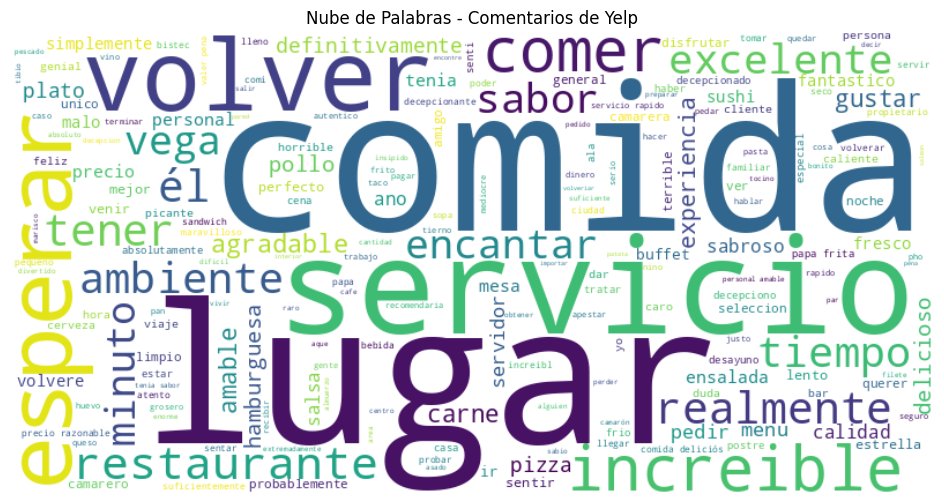

In [50]:
# Filtrar el DataFrame
df_yelp = df[df['Origen'] == 'yelp']

# Unir todos los lemas en un solo string (comentarios lematizados ya están en listas)
texto_yelp = ' '.join([' '.join(lemas) for lemas in df_yelp['Comentarios_lema']])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_yelp)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Comentarios de Yelp")
plt.show()


### Word cloud de Amazon

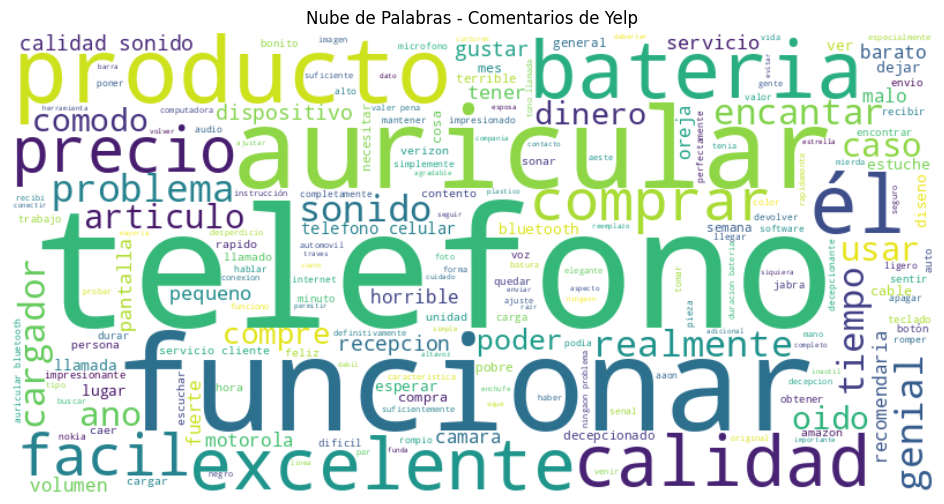

In [51]:
# Filtrar el DataFrame
df_amazon = df[df['Origen'] == 'amazon']

# Unir todos los lemas en un solo string (comentarios lematizados ya están en listas)
texto_amazon = ' '.join([' '.join(lemas) for lemas in df_amazon['Comentarios_lema']])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_amazon)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Comentarios de Yelp")
plt.show()


## Conteo de Palabras mas comunes

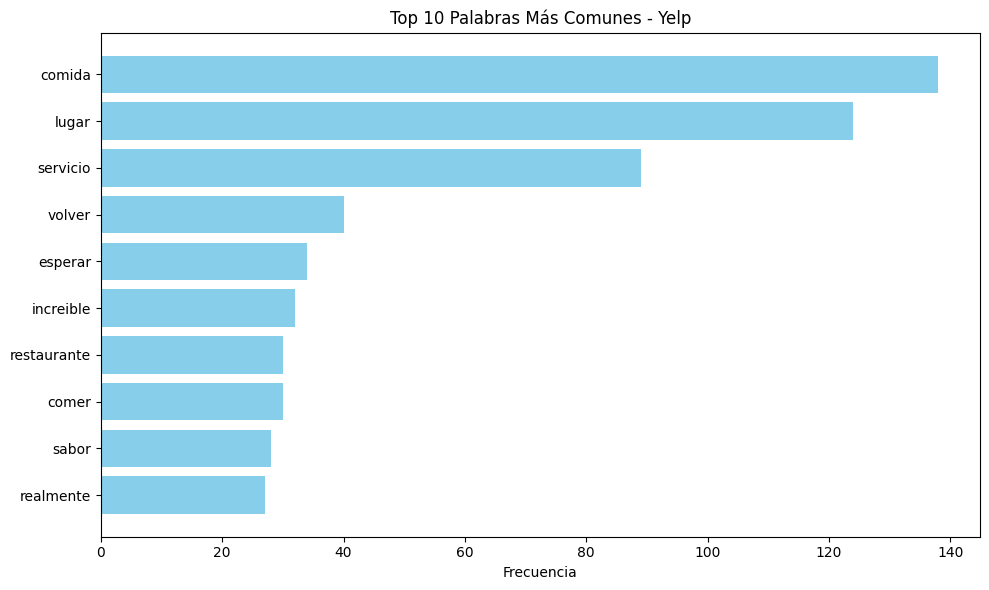

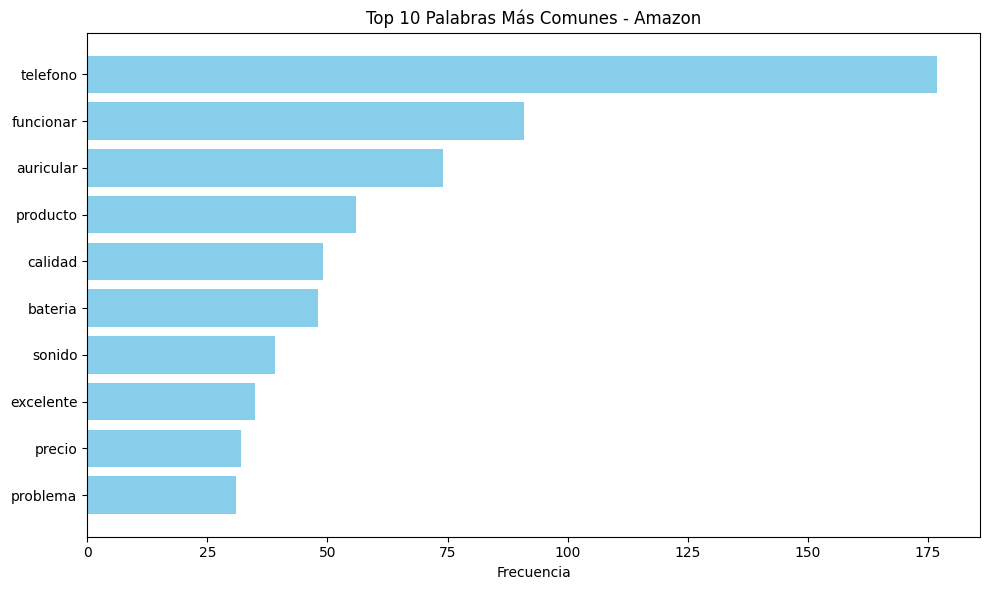

In [52]:
def graficar_palabras_comunes(df, origen, top_n=10):
    # Filtrar y aplanar los lemas
    lemas = [lema for lemas in df[df['Origen'] == origen]['Comentarios_lema'] for lema in lemas]
    conteo = Counter(lemas).most_common(top_n)

    # Separar palabras y frecuencias
    palabras, frecuencias = zip(*conteo)

    # Crear gráfico
    plt.figure(figsize=(10, 6))
    plt.barh(palabras, frecuencias, color='skyblue')
    plt.xlabel('Frecuencia')
    plt.title(f'Top {top_n} Palabras Más Comunes - {origen.capitalize()}')
    plt.gca().invert_yaxis()  # Poner la palabra más común arriba
    plt.tight_layout()
    plt.show()

# Graficar para Yelp
graficar_palabras_comunes(df, 'yelp')

# Graficar para Amazon
graficar_palabras_comunes(df, 'amazon')


## Bigramas + WordCloud

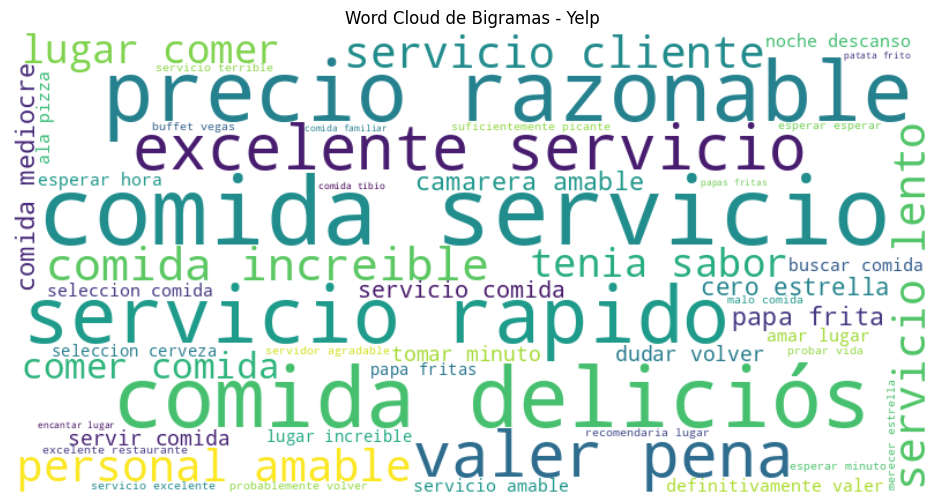

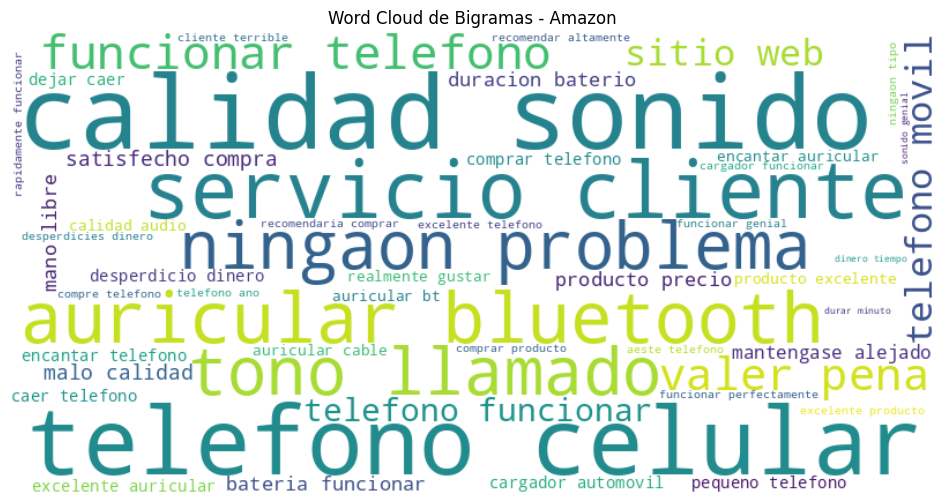

In [53]:
def generar_bigramas_spacy(df, origen, top_n=50):
    """
    Genera bigramas usando spaCy a partir de la columna 'Comentarios_Lema', sin stopwords.
    Luego genera una nube de palabras.
    """
    # Filtrar los comentarios por 'origen' (por ejemplo, 'yelp' o 'amazon')
    comentarios = df[df['Origen'] == origen]['Comentarios_lema']

    # Generar bigramas
    bigramas = []
    for comentario in comentarios:
        # Crear un Doc de spaCy a partir de la lista de lemas (de la columna 'Comentarios_Lema')
        doc = nlp(' '.join(comentario))  # Unimos la lista de lemas y lo procesamos con spaCy
        # Extraer bigramas
        for i in range(len(doc) - 1):
            if not doc[i].is_stop and not doc[i+1].is_stop:  # Asegurarse de que no sean stopwords
                bigramas.append((doc[i].lemma_, doc[i+1].lemma_))

    # Contar los bigramas más comunes
    conteo_bigramas = Counter(bigramas).most_common(top_n)

    # Convertir los bigramas a formato texto "palabra1 palabra2"
    bigramas_texto = {' '.join(bigrama): freq for bigrama, freq in conteo_bigramas}

    # Generar la nube de palabras de los bigramas
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigramas_texto)

    # Mostrar la nube
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud de Bigramas - {origen.capitalize()}")
    plt.show()

# Generar la nube de bigramas para Yelp y Amazon
generar_bigramas_spacy(df, 'yelp')
generar_bigramas_spacy(df, 'amazon')


## 🚀 Análisis de sentimiento en español con pysentimiento

###Procesamiento del sentimiento con los comentarios sin procesar.

In [54]:
from pysentimiento import create_analyzer

# Crear analizador de sentimientos
analyzer = create_analyzer(task="sentiment", lang="es")

# Aplicar a una columna de texto
df['Sentimiento'] = df['Comentarios'].apply(lambda x: analyzer.predict(x).output)
# Sentimiento solo guarda lo predicho (POS, NEU o NEG)

df['Probabilidad'] = df['Comentarios'].apply(lambda x: analyzer.predict(x).probas)
#Ese diccionario contiene la probabilidad de cada clase: positivo, neutro, negativo Ejemplo: {'POS': 0.84, 'NEU': 0.10, 'NEG': 0.06}.



### 📊  Gráfico de barras de frecuencia de sentimientos


### Análisis de sentimientos con todos los datos de yelp y Amazon juntos.

<ipython-input-55-a75de3f36333>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')


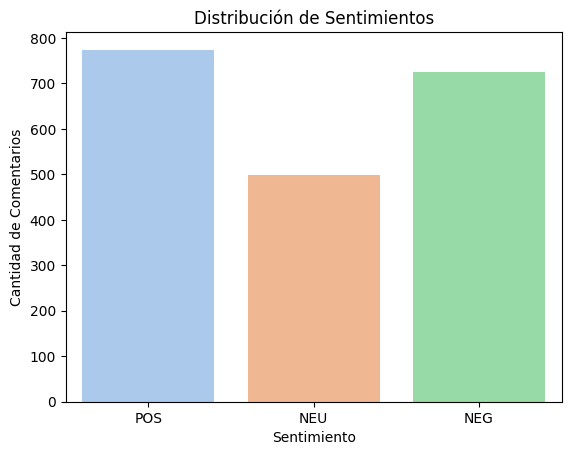

In [55]:
sns.countplot(data=df, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Comentarios')
plt.show()


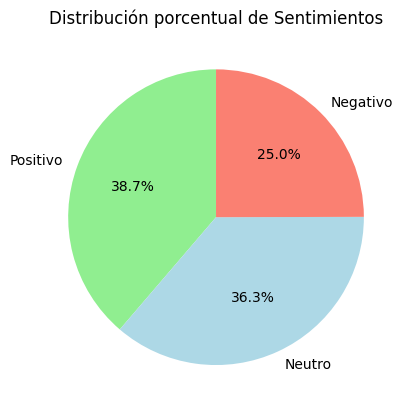

In [56]:
df['Sentimiento'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    labels=['Positivo', 'Neutro', 'Negativo'],
    colors=['lightgreen', 'lightblue', 'salmon']
)
plt.title('Distribución porcentual de Sentimientos')
plt.ylabel('')
plt.show()

### Distribución de sentiminetos de los comentarios de Yelp

<ipython-input-57-781cc1cb73e8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_yelp, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')


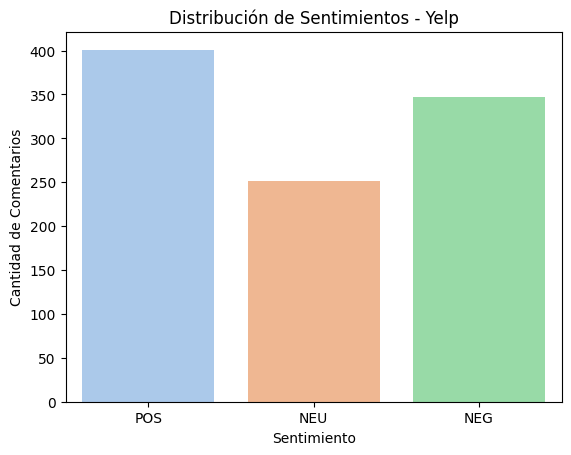

In [57]:
# Filtrar por origen "yelp"
df_yelp = df[df['Origen'] == 'yelp']

# Graficar los sentimientos de Yelp
sns.countplot(data=df_yelp, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')
plt.title('Distribución de Sentimientos - Yelp')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Comentarios')
plt.show()

### Distribución de sentiminetos de los comentarios de Amazon

<ipython-input-58-cfdefd8a5715>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_amazon, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')


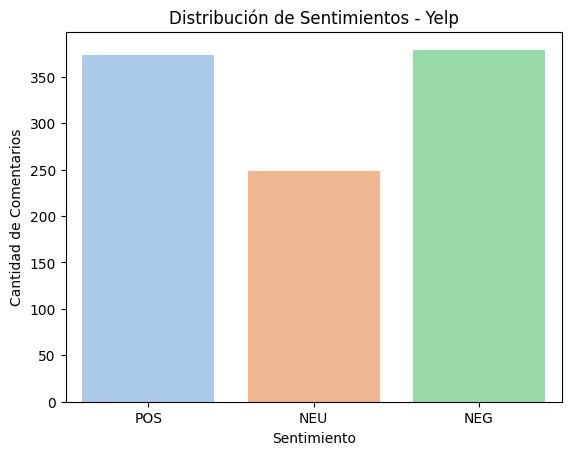

In [58]:
# Filtrar por origen "amazon"
df_amazon = df[df['Origen'] == 'amazon']

# Graficar los sentimientos de Yelp
sns.countplot(data=df_amazon, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')
plt.title('Distribución de Sentimientos - Yelp')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Comentarios')
plt.show()

### Distribución de sentimientos pero con los datos lematizados.

In [59]:

resultados = [analyzer.predict(texto) for texto in df['Comentarios_lema'].apply(' '.join)]

# Aplicar a una columna de texto
df['Sentimiento_lema'] = [resultado.output for resultado in resultados]
df['Probabilidad_lema'] = [resultado.probas for resultado in resultados]

<ipython-input-60-883f28cbf286>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_amazon, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')


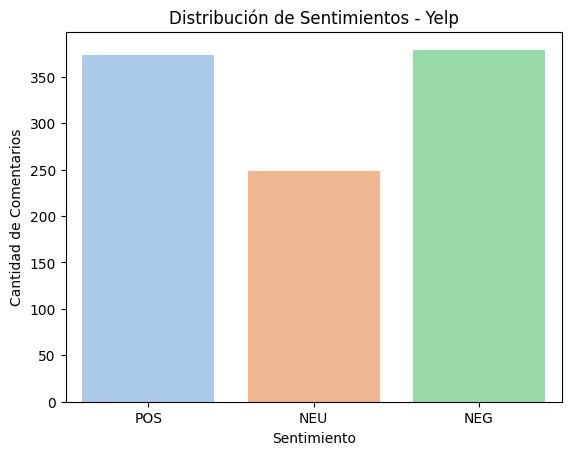

In [60]:
# Filtrar por origen "yelp"
df_amazon = df[df['Origen'] == 'amazon']

# Graficar los sentimientos de Yelp
sns.countplot(data=df_amazon, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')
plt.title('Distribución de Sentimientos - Yelp')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Comentarios')
plt.show()

#### No se observan cambios respecto al análisis realizado con las frases sin lematizar.

### Análisis de Confianza para filtrar comentarios con baja certeza

In [61]:
# Máxima probabilidad (nivel de certeza del modelo)
df['Confianza'] = df['Probabilidad'].apply(lambda x: max(x.values()))  # En este caso, de la lista {'POS': 0.84, 'NEU': 0.10, 'NEG': 0.06} sólo guarda 0.84 que es el valor mayor

In [62]:
# Filtrar comentarios cuya confianza sea menor a 0.6
comentarios_baja_confianza = df[df['Confianza'] < 0.6]

# Ver los primeros resultados
comentarios_baja_confianza[['Comentarios', 'Sentimiento', 'Confianza']]

,Comentarios,Sentimiento,Confianza
6,Honestamente no sabia tan fresco,NEU,0.570312
7,Las papas eran como caucho y se notaba que se ...,NEU,0.572579
13,Probe el ravoli de Cape Cod pollo con arandano...,POS,0.523901
16,Muy recomendable,POS,0.495531
20,Los Burrittos Blah,NEU,0.480604
...,...,...,...
991,Doloroso en la oreja,NEU,0.468931
992,Duro un dia y luego exploto,NEG,0.575744
993,decepcionado,NEG,0.581094
994,Tipo de fracasos alrededor,NEU,0.468940


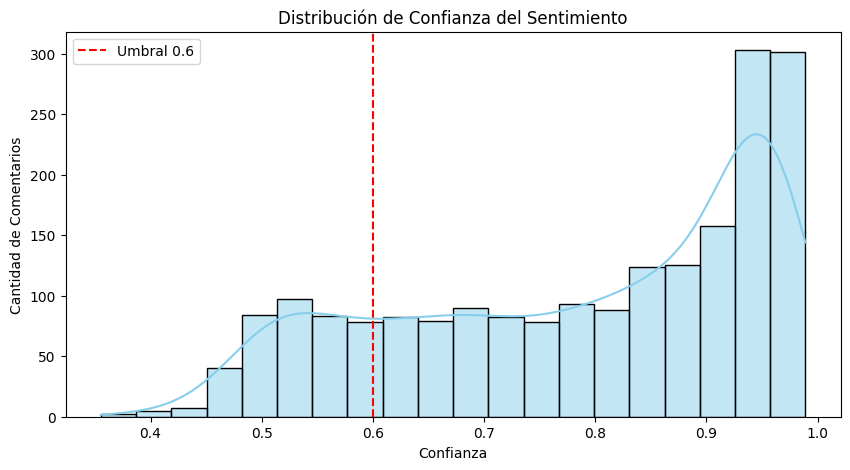

In [63]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Confianza', bins=20, kde=True, color='skyblue')
plt.axvline(0.6, color='red', linestyle='--', label='Umbral 0.6')
plt.title('Distribución de Confianza del Sentimiento')
plt.xlabel('Confianza')
plt.ylabel('Cantidad de Comentarios')
plt.legend()
plt.show()

<ipython-input-64-2eaacf4e20f2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sentimiento', y='Confianza', order=['POS', 'NEU', 'NEG'], palette='pastel')


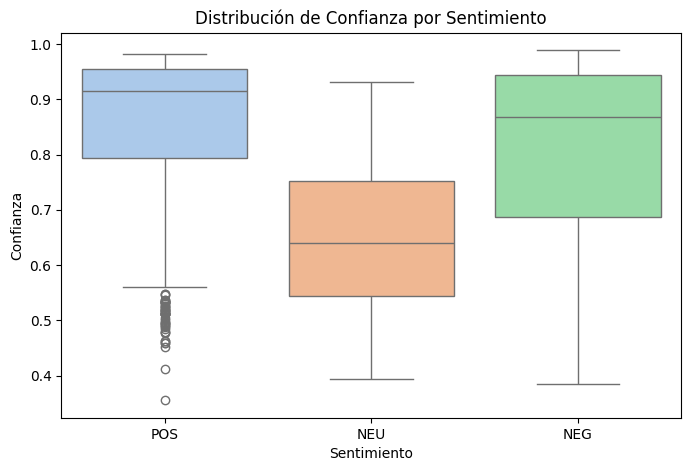

In [64]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Sentimiento', y='Confianza', order=['POS', 'NEU', 'NEG'], palette='pastel')
plt.title('Distribución de Confianza por Sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('Confianza')
plt.show()

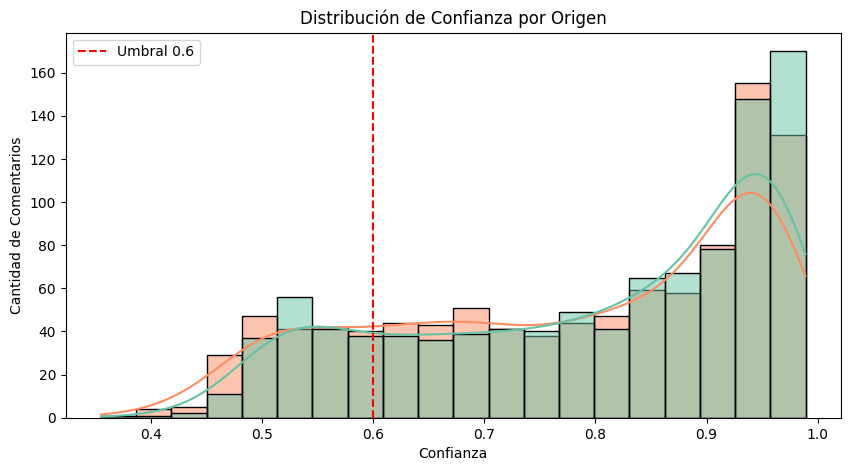

In [65]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Confianza', hue='Origen', bins=20, kde=True, palette='Set2')
plt.axvline(0.6, color='red', linestyle='--', label='Umbral 0.6')
plt.title('Distribución de Confianza por Origen')
plt.xlabel('Confianza')
plt.ylabel('Cantidad de Comentarios')
plt.legend()
plt.show()

In [66]:
df_baja_confianza = df[df['Confianza'] < 0.6]


In [67]:
 #Unir todos los lemas en un solo string (asumiendo que cada fila de 'Comentarios_lema' es una lista de palabras)
texto_baja_confianza = ' '.join([' '.join(lemas) for lemas in df_baja_confianza['Comentarios_lema']])

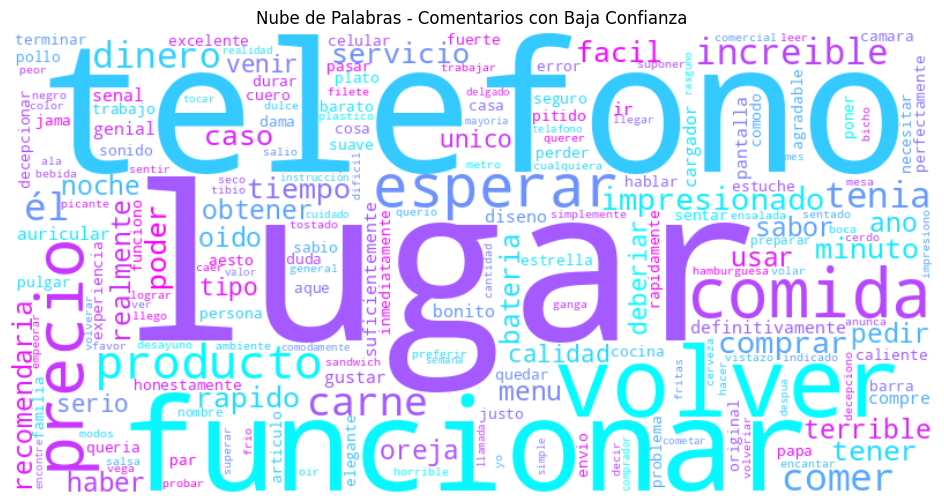

In [68]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='cool').generate(texto_baja_confianza)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Comentarios con Baja Confianza")
plt.show()

# TF_IDF

## 🌟 Explicación del TF-IDF

TF-IDF (Term Frequency - Inverse Document Frequency) es una técnica de procesamiento de texto utilizada para evaluar la importancia de una palabra dentro de un conjunto de documentos. Se basa en dos conceptos:

TF (Frecuencia de Término): Mide cuántas veces aparece un término en un documento específico, comparado con el número total de términos en ese documento.
Esto ayuda a capturar cuán relevante es una palabra dentro de un documento en particular.

IDF (Frecuencia Inversa de Documentos): Mide la importancia de una palabra dentro de un conjunto de documentos. Si una palabra aparece en muchos documentos, tiene menos valor. La fórmula es:

Esto ayuda a reducir el peso de las palabras que aparecen frecuentemente en todos los documentos (como "el", "y", "de"), ya que no agregan mucha información.

Así, la importancia de un término en un documento depende tanto de su frecuencia en ese documento como de cuán común es en todo el conjunto de documentos.

## 1. TFIDF espera trabajar con strings y  no listas, por lo que se procesde a crear una nueva columna con los datos lematizados en formato str.

In [69]:
df['Comentarios_lema_str'] = df['Comentarios_lema'].apply(lambda x: ' '.join(x))


## 2. Cálculo de TF-IDF con TfidVetorizer.

In [119]:
# Crear el vectorizador
tfidfvectorizer = TfidfVectorizer(max_features=5000)

# Ajustar y transformar
tfidf_matrix = tfidfvectorizer.fit_transform(df['Comentarios_lema_str'])

# Obtener los términos
features = tfidfvectorizer.get_feature_names_out()

## 3. Convertir a dataframe para posterior análisis.

In [120]:
# Crear DataFrame TF-IDF
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=features)

# Sumamos por columna para ver los términos más importantes globalmente
tfidf_scores = df_tfidf.sum().sort_values(ascending=False)

# Mostrar top 10
print(tfidf_scores.head(10).round(3))

telefono     53.929
comida       45.156
servicio     43.023
lugar        42.580
funcionar    40.381
producto     27.100
auricular    25.440
precio       23.988
volver       23.539
calidad      23.413
dtype: float64


## 3. Aplicando TF-IDF y Gráficos

### Gráfico de todos los comentarios (Yelp y Amanzon)

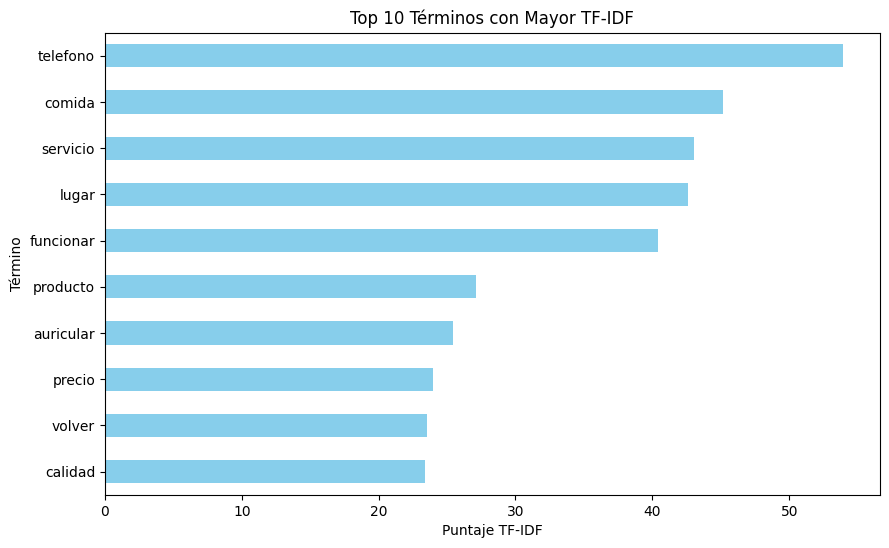

In [76]:

# Tomar los 10 términos con mayor puntuación TF-IDF
top_tfidf = tfidf_scores.head(10)

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
top_tfidf.plot(kind='barh', color='skyblue')
plt.title("Top 10 Términos con Mayor TF-IDF")
plt.xlabel("Puntaje TF-IDF")
plt.ylabel("Término")
plt.gca().invert_yaxis()  # Para que el mayor quede arriba
plt.show()

### Gráfico para comentarios de YELP

<Figure size 1000x600 with 0 Axes>

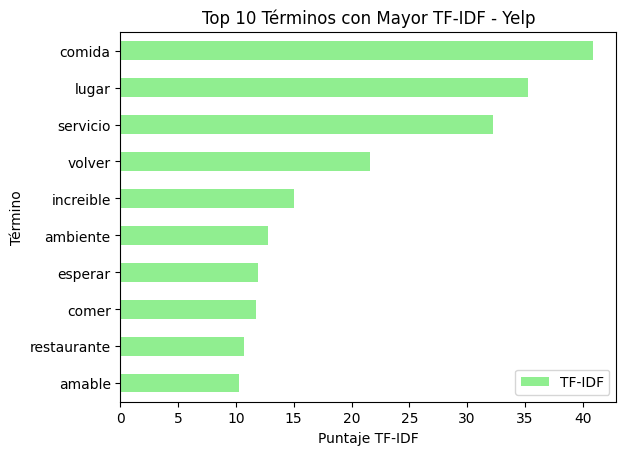

In [82]:
# Filtrar comentarios de Yelp
df_yelp = df[df['Origen'] == 'yelp']

# Calcular TF-IDF solo para los comentarios de Yelp
tfidf_yelp_matrix = vectorizer.fit_transform(df_yelp['Comentarios_lema_str'])
tfidf_yelp_scores = tfidf_yelp_matrix.sum(axis=0).A1  # Sumar por columna
yelp_features = vectorizer.get_feature_names_out()

# Crear DataFrame con resultados
df_yelp_tfidf = pd.DataFrame(tfidf_yelp_scores, index=yelp_features, columns=['TF-IDF'])
df_yelp_tfidf = df_yelp_tfidf.sort_values(by='TF-IDF', ascending=False)

# Graficar los top 10 términos de Yelp
plt.figure(figsize=(10, 6))
df_yelp_tfidf.head(10).plot(kind='barh', color='lightgreen')
plt.title("Top 10 Términos con Mayor TF-IDF - Yelp")
plt.xlabel("Puntaje TF-IDF")
plt.ylabel("Término")
plt.gca().invert_yaxis()
plt.show()

### Gráfico para comentarios de Amazon

<Figure size 1000x600 with 0 Axes>

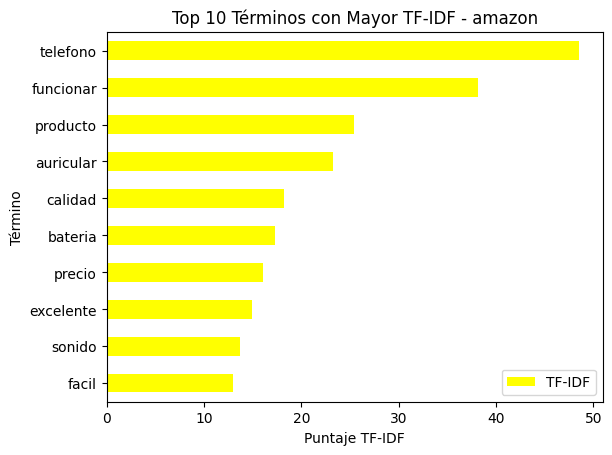

In [84]:
# Filtrar comentarios de Amazon
df_amazon = df[df['Origen'] == 'amazon']

# Calcular TF-IDF solo para los comentarios de Amazon
tfidf_amazon_matrix = vectorizer.fit_transform(df_amazon['Comentarios_lema_str'])
tfidf_amazon_scores = tfidf_amazon_matrix.sum(axis=0).A1  # Sumar por columna
amazon_features = vectorizer.get_feature_names_out()

# Crear DataFrame con resultados
df_amazon_tfidf = pd.DataFrame(tfidf_amazon_scores, index=amazon_features, columns=['TF-IDF'])
df_amazon_tfidf = df_amazon_tfidf.sort_values(by='TF-IDF', ascending=False)

# Graficar los top 10 términos de Amazon
plt.figure(figsize=(10, 6))
df_amazon_tfidf.head(10).plot(kind='barh', color='yellow')
plt.title("Top 10 Términos con Mayor TF-IDF - amazon")
plt.xlabel("Puntaje TF-IDF")
plt.ylabel("Término")
plt.gca().invert_yaxis()
plt.show()

# BoW (Bag of Words).

BoW convierte un conjunto de documentos en una matriz de ocurrencias de palabras. A diferencia de TF-IDF, que pondera las palabras según su frecuencia e importancia en relación con todo el corpus, BoW solo cuenta cuántas veces aparece una palabra en un documento sin considerar la frecuencia global de la palabra.

In [91]:
# Instanciamos el vectorizador BoW
vectorizer_bow = CountVectorizer()

# Aplicamos el vectorizador a los comentarios lematizados
X_bow = vectorizer_bow.fit_transform(df['Comentarios_lema_str'])

# Convertimos la matriz de características en un DataFrame para visualizar
bow_df = pd.DataFrame(X_bow.toarray(), columns=vectorizer_bow.get_feature_names_out())

# Obtener los nombres de las características (palabras)
features_bow = vectorizer_bow.get_feature_names_out()

# Crear un DataFrame con las frecuencias de las palabras
df_bow = pd.DataFrame(X_bow.toarray(), columns=features_bow)

# Sumar las frecuencias de palabras por columna
bow_word_frequencies = df_bow.sum().sort_values(ascending=False)

# Mostrar las top 10 palabras más frecuentes
print(bow_word_frequencies.head(10))

telefono     177
comida       138
lugar        136
servicio     112
funcionar     91
auricular     74
él            70
calidad       64
excelente     58
producto      56
dtype: int64


<ipython-input-92-9efe526a5f83>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words.index, y=top_words.values, palette='viridis')


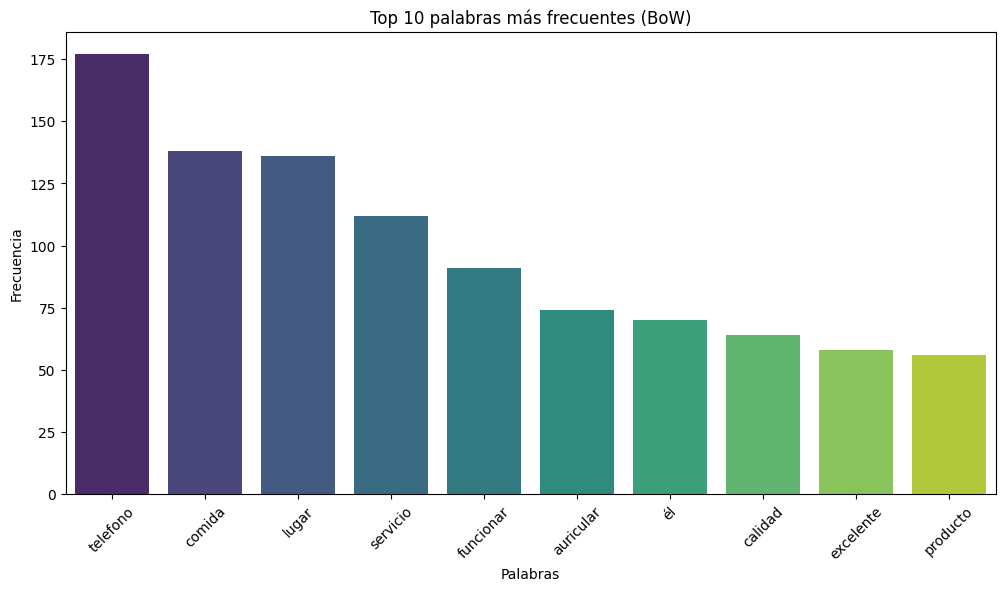

In [92]:
# Gráfico de las 10 palabras más frecuentes en BoW
top_words = bow_word_frequencies.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_words.index, y=top_words.values, palette='viridis')
plt.title('Top 10 palabras más frecuentes (BoW)')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

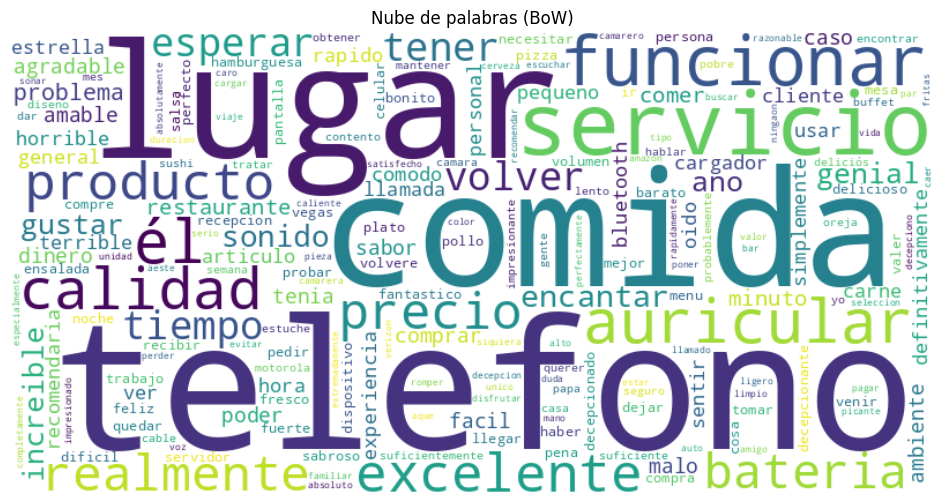

In [93]:
# Crear la nube de palabras con BoW
wordcloud_bow = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bow_word_frequencies)

# Mostrar la nube de palabras
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_bow, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras (BoW)")
plt.show()

# Pruebas de Modelos de Machine Learning

### Separación Train-Test

In [95]:
# Defino las características (X) y las etiquetas (y)
X = df_tfidf  # Las características son los valores del TF-IDF
y = df['Valor']  # La variable objetivo es 'Valor' (0 o 1)

# Paso 2: Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Regresión Logistica

### Entrenamiento del modelo.

In [97]:
# Crear y entrenar el modelo de regresión logística
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Realizar predicción con Test y evaluar el Accuarcy

In [98]:
# Hacer predicciones
y_pred_logreg = logreg_model.predict(X_test)

# Evaluar precisión
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f'Precisión de la regresión logística: {accuracy_logreg:.3f}')

Precisión de la regresión logística: 0.735


### Evaluacion del modelo.

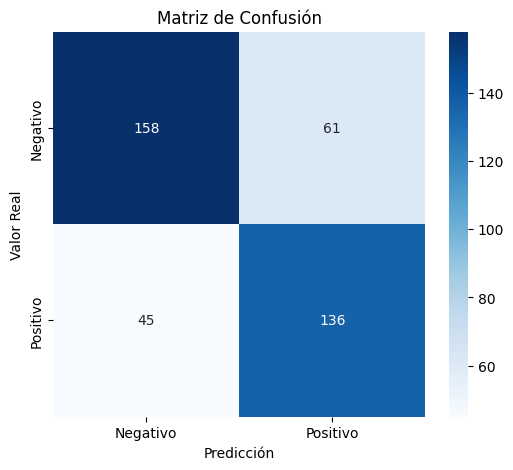

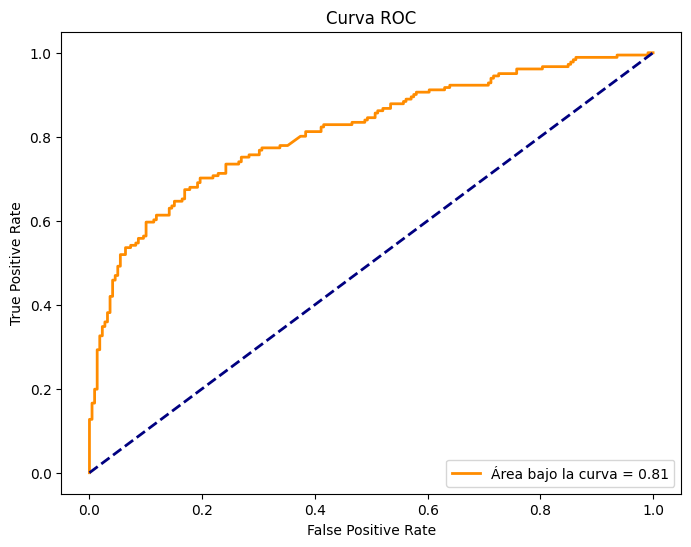

Métricas de desempeño del modelo:
Accuracy : 0.73
Precision: 0.69
Recall   : 0.75
F1 Score : 0.72


In [111]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Matriz de confusión
cm = confusion_matrix(y_test, y_pred_logreg)
labels = ['Negativo', 'Positivo']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

# 2. Curva ROC
fpr, tpr, _ = roc_curve(y_test, logreg_model.decision_function(X_test))
roc_auc = roc_auc_score(y_test, logreg_model.decision_function(X_test))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Área bajo la curva = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# 3. Métricas
accuracy = accuracy_score(y_test, y_pred_logreg)
precision = precision_score(y_test, y_pred_logreg)
recall = recall_score(y_test, y_pred_logreg)
f1 = f1_score(y_test, y_pred_logreg)

print("Métricas de desempeño del modelo:")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")


📊 Métricas basadas en la matriz:
True Positives (TP) = 136 → positivos bien predichos

True Negatives (TN) = 158 → negativos bien predichos

False Positives (FP) = 61 → negativos clasificados como positivos

False Negatives (FN) = 45 → positivos clasificados como negativos

📊 Métricas basadas en el desempeño:

🔹 Accuracy (0.73): el modelo predice correctamente el 73% de los casos totales.

🔹 Precision (0.69): de todos los comentarios que el modelo predijo como positivos, el 69% realmente lo eran. Podría estar dando algunos falsos positivos.

🔹 Recall (0.75): de todos los comentarios positivos reales, el modelo logró detectar el 75%. Esto está bastante bien.

🔹 F1 Score (0.72): el equilibrio entre precisión y recall es bueno.

### Prueba de modelo

In [131]:
nueva_reseña = "Estoy disconforme con la atención"  # Reemplaza con la reseña que deseas probar
nueva_reseña_tfidf = tfidfvectorizer.transform([nueva_reseña])
prediccion = logreg_model.predict(nueva_reseña_tfidf)

# Obtener la probabilidad de la predicción
probabilidadpositiva = logreg_model.predict_proba(nueva_reseña_tfidf)

# Obtener la probabilidad en la clase predicha (0 o 1)
probabilidad = probabilidadpositiva[0][1]  # Probabilidad de la clase "positivo"

print(f"Se predice que la crítica es de caracter {prediccion[0]}")
print(f" con una probabilidad de que sea positiva de {probabilidad:.2f}")


Se predice que la crítica es de caracter 0
 con una probabilidad de que sea positiva de 0.48


## Buscando el mejor modelo

### Validación Cruzada del modelo.

Precisión media (F1 = 0.742): el modelo logra un buen equilibrio entre precisión y recall.

Desviación estándar baja (±0.026): hay poca variación entre los diferentes subconjuntos de datos usados durante la validación cruzada, lo que sugiere que el modelo generaliza bien.

In [134]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Pipeline: vectorización + modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear'))
])

# Definir el espacio de búsqueda
param_grid = {
    'tfidf__max_df': [0.8, 1.0],
    'tfidf__min_df': [1, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10]  # regularización de la regresión logística
}

# GridSearch con validación cruzada
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Entrenar
grid.fit(df['Comentarios_lema_str'], df['Valor'])

# Mejor modelo
print("Mejores parámetros encontrados:")
print(grid.best_params_)
print(f"Mejor F1 score: {grid.best_score_:.3f}")

modelo_best = grid.best_params_



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros encontrados:
{'clf__C': 10, 'tfidf__max_df': 0.8, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Mejor F1 score: 0.742


In [133]:
from sklearn.model_selection import cross_val_score
# Validación cruzada con 5 particiones (k-fold = 5)
scores = cross_val_score(pipeline, df['Comentarios_lema_str'], df['Valor'], cv=5, scoring='accuracy')

# Resultados
print(f"Precisión media con validación cruzada: {scores.mean():.3f}")
print(f"Desviación estándar: {scores.std():.3f}")


Precisión media con validación cruzada: 0.740
Desviación estándar: 0.026
